# F1tenth

In [2]:
import gym
import numpy as np



## Environment playground

In [5]:
# racecar_env = gym.make(
#     'f110_gym:f110-v0',
#     map='./f1tenth_gym/gym/f110_gym/envs/maps/vegas',
#     map_ext='.png'
# )

racecar_env = gym.make(
    'f110_gym:f110-v0',
    map='./f1tenth_gym/examples/example_map',
    map_ext='.png'
)

In [4]:
obs, step_reward, done, info = racecar_env.reset(
    poses=np.array([[0., 0., 0.], # pose of ego
             [2., 0., 0.]])  # pose of 2nd agent
) 

obs

{'ego_idx': 0,
 'scans': [array([29.98576175, 30.01263728, 29.99129338, ..., 29.99864406,
         29.9889291 , 30.01278365]),
  array([29.98576175, 30.01263728, 29.99129338, ..., 29.99864406,
         29.9889291 , 30.01278365])],
 'poses_x': [0.0, 2.0],
 'poses_y': [0.0, 0.0],
 'poses_theta': [0.0, 0.0],
 'linear_vels_x': [0.0, 0.0],
 'linear_vels_y': [0.0, 0.0],
 'ang_vels_z': [0.0, 0.0],
 'collisions': array([0., 0.]),
 'lap_times': array([0.01, 0.01]),
 'lap_counts': array([0., 0.])}

In [5]:
state = np.concatenate([
    obs['scans'][0],
    np.array(obs['linear_vels_x'][:1]),
    np.array(obs['linear_vels_y'][:1]),
])
state.shape

(1082,)

In [6]:
speeds = np.random.rand(2, 1)*2
pi_4 = 3.1415/8
pi_2 = 3.1415/4
angles = np.random.rand(2, 1)*pi_2-pi_4
actions = np.concatenate([angles, speeds], axis=1)

actions

array([[-0.0596855 ,  0.44670051],
       [-0.05675966,  1.8354974 ]])

In [2]:
## action consists of ndarray(num_agent, 2) 0: steering angle 1: velocity
## the reward function is only for the first agent

import time
import gym 
import numpy as np


racecar_env = gym.make(
    'f110_gym:f110-v0',
    map='./f1tenth_gym/examples/example_map',
    map_ext='.png',
    num_agents=1
)
steps = 0

obs, step_reward, done, info = racecar_env.reset(
    poses=np.array([[0., 0., 1.5]]) 
) 

rewards = []

while not done:
    
    speeds = np.random.rand(2, 1)*20
    pi_4 = 3.1415/8
    pi_2 = 3.1415/4
    speeds[1][0] = 0.1
    angles = np.random.rand(2, 1)*pi_2-pi_4
    actions = np.concatenate([angles, speeds], axis=1)

    obs, step_reward, done, info = racecar_env.step(actions)
    rewards.append(step_reward)
    
    racecar_env.render()
    steps += 1
    
    if steps > 500:
        break

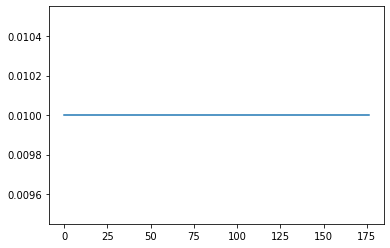

In [16]:
import matplotlib.pyplot as plt

plt.plot(rewards)

## Define environment wrapper

### waypoints

In [ ]:
import time
import yaml
import gym
import numpy as np
from argparse import Namespace

from numba import njit

from pyglet.gl import GL_POINTS


# @njit(fastmath=False, cache=True)
def nearest_point_on_trajectory(point, trajectory):
    """
    Return the nearest point along the given piecewise linear trajectory.

    Same as nearest_point_on_line_segment, but vectorized. This method is quite fast, time constraints should
    not be an issue so long as trajectories are not insanely long.

        Order of magnitude: trajectory length: 1000 --> 0.0002 second computation (5000fps)

    point: size 2 numpy array
    trajectory: Nx2 matrix of (x,y) trajectory waypoints
        - these must be unique. If they are not unique, a divide by 0 error will destroy the world
    """
    diffs = trajectory[1:,:] - trajectory[:-1,:]
    l2s   = diffs[:,0]**2 + diffs[:,1]**2
    # this is equivalent to the elementwise dot product
    # dots = np.sum((point - trajectory[:-1,:]) * diffs[:,:], axis=1)
    dots = np.empty((trajectory.shape[0]-1, ))
    for i in range(dots.shape[0]):
        dots[i] = np.dot((point - trajectory[i, :]), diffs[i, :])
    t = dots / l2s
    t[t<0.0] = 0.0
    t[t>1.0] = 1.0
    # t = np.clip(dots / l2s, 0.0, 1.0)
    projections = trajectory[:-1,:] + (t*diffs.T).T
    # dists = np.linalg.norm(point - projections, axis=1)
    dists = np.empty((projections.shape[0],))
    for i in range(dists.shape[0]):
        temp = point - projections[i]
        dists[i] = np.sqrt(np.sum(temp*temp))
    min_dist_segment = np.argmin(dists)
    return projections[min_dist_segment], dists[min_dist_segment], t[min_dist_segment], min_dist_segment

# @njit(fastmath=False, cache=True)
def first_point_on_trajectory_intersecting_circle(point, radius, trajectory, t=0.0, wrap=False):
    """
    starts at beginning of trajectory, and find the first point one radius away from the given point along the trajectory.

    Assumes that the first segment passes within a single radius of the point

    http://codereview.stackexchange.com/questions/86421/line-segment-to-circle-collision-algorithm
    """
    start_i = int(t)
    start_t = t % 1.0
    first_t = None
    first_i = None
    first_p = None
    trajectory = np.ascontiguousarray(trajectory)
    for i in range(start_i, trajectory.shape[0]-1):
        start = trajectory[i,:]
        end = trajectory[i+1,:]+1e-6
        V = np.ascontiguousarray(end - start)

        a = np.dot(V,V)
        b = 2.0*np.dot(V, start - point)
        c = np.dot(start, start) + np.dot(point,point) - 2.0*np.dot(start, point) - radius*radius
        discriminant = b*b-4*a*c

        if discriminant < 0:
            continue
        #   print "NO INTERSECTION"
        # else:
        # if discriminant >= 0.0:
        discriminant = np.sqrt(discriminant)
        t1 = (-b - discriminant) / (2.0*a)
        t2 = (-b + discriminant) / (2.0*a)
        if i == start_i:
            if t1 >= 0.0 and t1 <= 1.0 and t1 >= start_t:
                first_t = t1
                first_i = i
                first_p = start + t1 * V
                break
            if t2 >= 0.0 and t2 <= 1.0 and t2 >= start_t:
                first_t = t2
                first_i = i
                first_p = start + t2 * V
                break
        elif t1 >= 0.0 and t1 <= 1.0:
            first_t = t1
            first_i = i
            first_p = start + t1 * V
            break
        elif t2 >= 0.0 and t2 <= 1.0:
            first_t = t2
            first_i = i
            first_p = start + t2 * V
            break
    # wrap around to the beginning of the trajectory if no intersection is found1
    if wrap and first_p is None:
        for i in range(-1, start_i):
            start = trajectory[i % trajectory.shape[0],:]
            end = trajectory[(i+1) % trajectory.shape[0],:]+1e-6
            V = end - start

            a = np.dot(V,V)
            b = 2.0*np.dot(V, start - point)
            c = np.dot(start, start) + np.dot(point,point) - 2.0*np.dot(start, point) - radius*radius
            discriminant = b*b-4*a*c

            if discriminant < 0:
                continue
            discriminant = np.sqrt(discriminant)
            t1 = (-b - discriminant) / (2.0*a)
            t2 = (-b + discriminant) / (2.0*a)
            if t1 >= 0.0 and t1 <= 1.0:
                first_t = t1
                first_i = i
                first_p = start + t1 * V
                break
            elif t2 >= 0.0 and t2 <= 1.0:
                first_t = t2
                first_i = i
                first_p = start + t2 * V
                break

    return first_p, first_i, first_t

# @njit(fastmath=False, cache=True)
def get_actuation(pose_theta, lookahead_point, position, lookahead_distance, wheelbase):
    """
    Returns actuation
    """
    waypoint_y = np.dot(np.array([np.sin(-pose_theta), np.cos(-pose_theta)]), lookahead_point[0:2]-position)
    speed = lookahead_point[2]
    if np.abs(waypoint_y) < 1e-6:
        return speed, 0.
    radius = 1/(2.0*waypoint_y/lookahead_distance**2)
    steering_angle = np.arctan(wheelbase/radius)
    return speed, steering_angle

class PurePursuitPlanner:
    """
    Example Planner
    """
    def __init__(self, conf, wb):
        self.wheelbase = wb
        self.conf = conf
        self.load_waypoints(conf)
        self.max_reacquire = 20.

        self.drawn_waypoints = []

    def load_waypoints(self, conf):
        """
        loads waypoints
        """
        self.waypoints = np.loadtxt(conf.wpt_path, delimiter=conf.wpt_delim, skiprows=conf.wpt_rowskip)

    def render_waypoints(self, e):
        """
        update waypoints being drawn by EnvRenderer
        """

        #points = self.waypoints

        points = np.vstack((self.waypoints[:, self.conf.wpt_xind], self.waypoints[:, self.conf.wpt_yind])).T
        
        scaled_points = 50.*points

        for i in range(points.shape[0]):
            if len(self.drawn_waypoints) < points.shape[0]:
                b = e.batch.add(1, GL_POINTS, None, ('v3f/stream', [scaled_points[i, 0], scaled_points[i, 1], 0.]),
                                ('c3B/stream', [183, 193, 222]))
                self.drawn_waypoints.append(b)
            else:
                self.drawn_waypoints[i].vertices = [scaled_points[i, 0], scaled_points[i, 1], 0.]
        
    def _get_current_waypoint(self, waypoints, lookahead_distance, position, theta):
        """
        gets the current waypoint to follow
        """
        wpts = np.vstack((self.waypoints[:, self.conf.wpt_xind], self.waypoints[:, self.conf.wpt_yind])).T
        nearest_point, nearest_dist, t, i = nearest_point_on_trajectory(position, wpts)
        if nearest_dist < lookahead_distance:
            lookahead_point, i2, t2 = first_point_on_trajectory_intersecting_circle(position, lookahead_distance, wpts, i+t, wrap=True)
            if i2 == None:
                return None
            current_waypoint = np.empty((3, ))
            # x, y
            current_waypoint[0:2] = wpts[i2, :]
            # speed
            current_waypoint[2] = waypoints[i, self.conf.wpt_vind]
            return current_waypoint
        elif nearest_dist < self.max_reacquire:
            return np.append(wpts[i, :], waypoints[i, self.conf.wpt_vind])
        else:
            return None

    def plan(self, pose_x, pose_y, pose_theta, lookahead_distance, vgain):
        """
        gives actuation given observation
        """
        position = np.array([pose_x, pose_y])
        lookahead_point = self._get_current_waypoint(self.waypoints, lookahead_distance, position, pose_theta)

        if lookahead_point is None:
            return 4.0, 0.0

        speed, steering_angle = get_actuation(pose_theta, lookahead_point, position, lookahead_distance, self.wheelbase)
        speed = vgain * speed

        return speed, steering_angle

def main():
    """
    main entry point
    """

    work = {'mass': 3.463388126201571, 'lf': 0.15597534362552312, 'tlad': 1.82461887897713965, 'vgain': 0.90338203837889}
    
    with open('./f1tenth_gym/examples/config_example_map.yaml') as file:
        conf_dict = yaml.load(file, Loader=yaml.FullLoader)
    conf = Namespace(**conf_dict)

    planner = PurePursuitPlanner(conf, 0.17145+0.15875)

    def render_callback(env_renderer):
        # custom extra drawing function

        e = env_renderer

        # update camera to follow car
        x = e.cars[0].vertices[::2]
        y = e.cars[0].vertices[1::2]
        top, bottom, left, right = max(y), min(y), min(x), max(x)
        e.score_label.x = left
        e.score_label.y = top - 700
        e.left = left - 800
        e.right = right + 800
        e.top = top + 800
        e.bottom = bottom - 800

        planner.render_waypoints(env_renderer)

    env = gym.make('f110_gym:f110-v0', map=conf.map_path, map_ext=conf.map_ext, num_agents=1)
    env.add_render_callback(render_callback)
    
    obs, step_reward, done, info = env.reset(np.array([[conf.sx, conf.sy, conf.stheta]]))
    env.render()

    laptime = 0.0
    start = time.time()

    while not done:
        speed, steer = planner.plan(obs['poses_x'][0], obs['poses_y'][0], obs['poses_theta'][0], work['tlad'], work['vgain'])
        obs, step_reward, done, info = env.step(np.array([[steer, speed]]))
        laptime += step_reward
        env.render(mode='human')
        
    print('Sim elapsed time:', laptime, 'Real elapsed time:', time.time()-start)

main()

### waypoint handler

In [3]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from argparse import Namespace



# @njit(fastmath=False, cache=True)
def nearest_point_on_trajectory(point, trajectory):
    """
    Return the nearest point along the given piecewise linear trajectory.

    Same as nearest_point_on_line_segment, but vectorized. This method is quite fast, time constraints should
    not be an issue so long as trajectories are not insanely long.

        Order of magnitude: trajectory length: 1000 --> 0.0002 second computation (5000fps)

    point: size 2 numpy array
    trajectory: Nx2 matrix of (x,y) trajectory waypoints
        - these must be unique. If they are not unique, a divide by 0 error will destroy the world
    """
    diffs = trajectory[1:,:] - trajectory[:-1,:]
    l2s   = diffs[:,0]**2 + diffs[:,1]**2
    # this is equivalent to the elementwise dot product
    # dots = np.sum((point - trajectory[:-1,:]) * diffs[:,:], axis=1)
    dots = np.empty((trajectory.shape[0]-1, ))
    for i in range(dots.shape[0]):
        dots[i] = np.dot((point - trajectory[i, :]), diffs[i, :])
    t = dots / l2s
    t[t<0.0] = 0.0
    t[t>1.0] = 1.0
    # t = np.clip(dots / l2s, 0.0, 1.0)
    projections = trajectory[:-1,:] + (t*diffs.T).T
    # dists = np.linalg.norm(point - projections, axis=1)
    dists = np.empty((projections.shape[0],))
    for i in range(dists.shape[0]):
        temp = point - projections[i]
        dists[i] = np.sqrt(np.sum(temp*temp))
    min_dist_segment = np.argmin(dists)
    return projections[min_dist_segment], dists[min_dist_segment], t[min_dist_segment], min_dist_segment

# @njit(fastmath=False, cache=True)
def first_point_on_trajectory_intersecting_circle(point, radius, trajectory, t=0.0, wrap=False):
    """
    starts at beginning of trajectory, and find the first point one radius away from the given point along the trajectory.

    Assumes that the first segment passes within a single radius of the point

    http://codereview.stackexchange.com/questions/86421/line-segment-to-circle-collision-algorithm
    """
    start_i = int(t)
    start_t = t % 1.0
    first_t = None
    first_i = None
    first_p = None
    trajectory = np.ascontiguousarray(trajectory)
    for i in range(start_i, trajectory.shape[0]-1):
        start = trajectory[i,:]
        end = trajectory[i+1,:]+1e-6
        V = np.ascontiguousarray(end - start)

        a = np.dot(V,V)
        b = 2.0*np.dot(V, start - point)
        c = np.dot(start, start) + np.dot(point,point) - 2.0*np.dot(start, point) - radius*radius
        discriminant = b*b-4*a*c

        if discriminant < 0:
            continue
        #   print "NO INTERSECTION"
        # else:
        # if discriminant >= 0.0:
        discriminant = np.sqrt(discriminant)
        t1 = (-b - discriminant) / (2.0*a)
        t2 = (-b + discriminant) / (2.0*a)
        if i == start_i:
            if t1 >= 0.0 and t1 <= 1.0 and t1 >= start_t:
                first_t = t1
                first_i = i
                first_p = start + t1 * V
                break
            if t2 >= 0.0 and t2 <= 1.0 and t2 >= start_t:
                first_t = t2
                first_i = i
                first_p = start + t2 * V
                break
        elif t1 >= 0.0 and t1 <= 1.0:
            first_t = t1
            first_i = i
            first_p = start + t1 * V
            break
        elif t2 >= 0.0 and t2 <= 1.0:
            first_t = t2
            first_i = i
            first_p = start + t2 * V
            break
    # wrap around to the beginning of the trajectory if no intersection is found1
    if wrap and first_p is None:
        for i in range(-1, start_i):
            start = trajectory[i % trajectory.shape[0],:]
            end = trajectory[(i+1) % trajectory.shape[0],:]+1e-6
            V = end - start

            a = np.dot(V,V)
            b = 2.0*np.dot(V, start - point)
            c = np.dot(start, start) + np.dot(point,point) - 2.0*np.dot(start, point) - radius*radius
            discriminant = b*b-4*a*c

            if discriminant < 0:
                continue
            discriminant = np.sqrt(discriminant)
            t1 = (-b - discriminant) / (2.0*a)
            t2 = (-b + discriminant) / (2.0*a)
            if t1 >= 0.0 and t1 <= 1.0:
                first_t = t1
                first_i = i
                first_p = start + t1 * V
                break
            elif t2 >= 0.0 and t2 <= 1.0:
                first_t = t2
                first_i = i
                first_p = start + t2 * V
                break

    return first_p, first_i, first_t
    
    
CAPTURE_TIME = 100
class F110Env(gym.Env):
    def __init__(self, env_config):
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,))
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(217,), dtype=np.float32)

        
        work = {'mass': 3.463388126201571, 'lf': 0.15597534362552312, 'tlad': 1.82461887897713965, 'vgain': 0.90338203837889}

        with open('./f1tenth_gym/examples/config_example_map.yaml') as file:
            conf_dict = yaml.load(file, Loader=yaml.FullLoader)
        conf = Namespace(**conf_dict)
        self.conf = conf
        self.load_waypoints(conf)
        self.max_reacquire = 20.

        def render_callback(env_renderer):
            # custom extra drawing function

            e = env_renderer

            # update camera to follow car
            x = e.cars[0].vertices[::2]
            y = e.cars[0].vertices[1::2]
            top, bottom, left, right = max(y), min(y), min(x), max(x)
            e.score_label.x = left
            e.score_label.y = top - 700
            e.left = left - 800
            e.right = right + 800
            e.top = top + 800
            e.bottom = bottom - 800


        self.env = gym.make('f110_gym:f110-v0', map=conf.map_path, map_ext=conf.map_ext, num_agents=1)
        self.env.add_render_callback(render_callback)
        self.prev_capture_coord = None
        self.reset()
        
    def load_waypoints(self, conf):
        """
        loads waypoints
        """
        self.waypoints = np.loadtxt(conf.wpt_path, delimiter=conf.wpt_delim, skiprows=conf.wpt_rowskip)

        
    def _get_current_waypoint(self, waypoints, lookahead_distance, position, theta):
        """
        gets the current waypoint to follow
        """
        wpts = np.vstack((self.waypoints[:, self.conf.wpt_xind], self.waypoints[:, self.conf.wpt_yind])).T
        nearest_point, nearest_dist, t, i = nearest_point_on_trajectory(position, wpts)
        if nearest_dist < lookahead_distance:
            lookahead_point, i2, t2 = first_point_on_trajectory_intersecting_circle(position, lookahead_distance, wpts, i+t, wrap=True)
            if i2 == None:
                return None
            current_waypoint = np.empty((3, ))
            # x, y
            current_waypoint[0:2] = wpts[i2, :]
            # speed
            current_waypoint[2] = waypoints[i, self.conf.wpt_vind]
            return current_waypoint
        elif nearest_dist < self.max_reacquire:
            return np.append(wpts[i, :], waypoints[i, self.conf.wpt_vind])
        else:
            return None
    
    def reset(self):
        obs, step_reward, done, info = self.env.reset(np.array([[self.conf.sx, self.conf.sy, self.conf.stheta]]))
        self.prev_capture_coord = [obs['poses_x'][0], obs['poses_y'][0]]
        self.time_to_capture = CAPTURE_TIME
        self.init_x = 0
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):

        scanner = np.zeros(1080//5,)
        for i in range(1080//5):
            scanner[i] = np.clip(np.mean(obs['scans'][0][i*5: i*5+5]), 0, 10)

        scanner /= 10
        state = np.concatenate([
            scanner,
            np.array(obs['linear_vels_x'][:1])/5,
        ])

        return state
    
    def step(self, action):
        

        action[0] = action[0]*np.pi/4
        action[1] = action[1]*2.5 + 2.5
        action = action.reshape(1, 2)
        action = np.repeat(action, repeats=2, axis=0)
        action[1][1] = 0
        # print(action)
        

        obs, step_reward, done, info = self.env.step(action)
        
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]
        
        position = np.array([pose_x, pose_y])
        lookahead_point = self._get_current_waypoint(self.waypoints, 1.8, position, 0.9033)
        
        print(position, lookahead_point)
        
        reward = 0
        if obs['collisions'][0] == 1.0:
            reward = -10
        

        next_state = self.to_vector_state(obs)
        reward += (step_reward + obs['linear_vels_x'][0]*0.01)

        self.time_to_capture -= 1
        return next_state, reward, done, info
    
    def render(self):
        self.env.render()



### checkpoint handler

In [41]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from argparse import Namespace

    
class F110Env(gym.Env):
    def __init__(self, env_config):
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,))
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(217,), dtype=np.float32)
        self.min_cp_dist = 1.0
        self.cp_reward = 5.0

        with open('./f1tenth_gym/examples/config_example_map.yaml') as file:
            conf_dict = yaml.load(file, Loader=yaml.FullLoader)
        conf = Namespace(**conf_dict)
        self.conf = conf
        wps = np.loadtxt(conf.wpt_path, delimiter=conf.wpt_delim, skiprows=conf.wpt_rowskip)[:, 1:3]
        idxs = [i%10 == 0 for i in range(len(wps))]
        self.checkpoints = wps[idxs]

        def render_callback(env_renderer):
            # custom extra drawing function

            e = env_renderer

            # update camera to follow car
            x = e.cars[0].vertices[::2]
            y = e.cars[0].vertices[1::2]
            top, bottom, left, right = max(y), min(y), min(x), max(x)
            e.score_label.x = left
            e.score_label.y = top - 700
            e.left = left - 800
            e.right = right + 800
            e.top = top + 800
            e.bottom = bottom - 800


        self.env = gym.make('f110_gym:f110-v0', map=conf.map_path, map_ext=conf.map_ext, num_agents=1)
        self.env.add_render_callback(render_callback)
        self.prev_capture_coord = None
        self.reset()
        
  
    def reset(self):
        obs, step_reward, done, info = self.env.reset(np.array([[self.conf.sx, self.conf.sy, self.conf.stheta]]))
        self.next_cp_idx = 0
        
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):

        scanner = np.zeros(1080//5,)
        for i in range(1080//5):
            scanner[i] = np.clip(np.mean(obs['scans'][0][i*5: i*5+5]), 0, 10)

        scanner /= 10
        state = np.concatenate([
            scanner,
            np.array(obs['linear_vels_x'][:1])/5,
        ])

        return state
    
    def checkpoint(self, position):
        dist = np.linalg.norm(position - self.checkpoints[self.next_cp_idx])
        reward = 0
        if dist < self.min_cp_dist:
            reward = self.cp_reward
            self.next_cp_idx = (self.next_cp_idx + 1)%len(self.checkpointsk)
        return reward
        
    def step(self, action):

        action[0] = action[0]*np.pi/4
        action[1] = action[1]*2.5 + 2.5
        action = action.reshape(1, 2)
        action = np.repeat(action, repeats=2, axis=0)
        action[1][1] = 0
        # print(action)
        

        obs, step_reward, done, info = self.env.step(action)
        
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]
        
        position = np.array([pose_x, pose_y])
        
        
        reward = 0
        if obs['collisions'][0] == 1.0:
            reward = -10
        
        cp_reward = self.checkpoint(position)
        
        next_state = self.to_vector_state(obs)
        reward += (cp_reward + obs['linear_vels_x'][0]*0.01)

        return next_state, reward, done, info
    
    def render(self):
        self.env.render()



## Env simple wrapper

In [9]:

CAPTURE_TIME = 100
class F110Env(gym.Env):
    def __init__(self, env_config):
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,))
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(217,), dtype=np.float32)
        
        self.env = gym.make(
            'f110_gym:f110-v0',
            map='./f1tenth_gym/examples/example_map',
            map_ext='.png'
        )
        
        self.reset()
        self.prev_capture_coord = None
        
    def reset(self):
        obs, step_reward, done, info = self.env.reset(
            poses=np.array([[0., 0., 0.], 
                     [-1., -1., 0.]]) 
        )
        self.prev_capture_coord = [obs['poses_x'][0], obs['poses_y'][0]]
        self.time_to_capture = CAPTURE_TIME
        self.init_x = 0
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):

        scanner = np.zeros(1080//5,)
        for i in range(1080//5):
            scanner[i] = np.clip(np.mean(obs['scans'][0][i*5: i*5+5]), 0, 10)

        scanner /= 10
        state = np.concatenate([
            scanner,
            np.array(obs['linear_vels_x'][:1])/5,
        ])

        return state
    
    def step(self, action):

        action[0] = action[0]*np.pi/4
        action[1] = action[1]*2.5 + 2.5
        action = action.reshape(1, 2)
        action = np.repeat(action, repeats=2, axis=0)
        action[1][1] = 0
        # print(action)
        obs, step_reward, done, info = self.env.step(action)
        reward = 0
        if obs['collisions'][0] == 1.0:
            reward = -10
        
        moving_forward_rew = 0

        if self.time_to_capture == 0:
            current_coord = [obs['poses_x'][0], obs['poses_y'][0]]
            dist = abs(current_coord[0] - self.prev_capture_coord[0]) + abs(current_coord[1] - self.prev_capture_coord[1])
            # print(f"prev coord:{self.prev_capture_coord}, current_coord:{current_coord}, dist:{dist}")
            
            self.prev_capture_coord = current_coord
            if dist < 2:
                # print("Neg reward")
                moving_forward_rew = -10

            self.time_to_capture = CAPTURE_TIME + 1

        next_state = self.to_vector_state(obs)
        # ang_vel = obs['ang_vels_z'][0]
        # print(obs['ang_vels_z'][0]*0.1)
        reward += (step_reward + obs['linear_vels_x'][0]*0.01)

        self.time_to_capture -= 1
        return next_state, reward, done, info
    
    def render(self):
        self.env.render()


## Render

In [ ]:
done = False
env = F110Env({'explore':False})
obs = env.reset()

while not done:
    action = np.array([1.0, 0.0])
    obs, reward, done, _ = env.step(action)
    env.render()

# RAY algorithms

In [42]:
import ray
from ray.rllib.agents import ppo

In [ ]:

gpu_configs = {
    "num_workers": 30,
    "framework": "torch",
    "model": {
        "fcnet_hiddens": [512, 512, 128],
        "fcnet_activation": "relu",
    },
    "evaluation_num_workers": 5,
    "evaluation_config": {
        "render_env": False,
    },
    "num_gpus": 2
}


config = {
    "num_workers": 1,
    "framework": "torch",
    "model": {
        "fcnet_hiddens": [512, 512, 128],
        "fcnet_activation": "relu",
    },
    "evaluation_num_workers": 1,
    "evaluation_config": {
        "render_env": False,
    },
}



ray.shutdown()
ray.init()
trainer = ppo.PPOTrainer(env=F110Env, config=config)

for i in range(100):

    result = trainer.train()
    print(f"episode: {i} reward:{result['episode_reward_mean']}")
    
    if i%10 == 0:
        cp = trainer.save("./rllib_checkpoint")
        print("checkpoint saved at", checkpoint)


In [109]:
trainer.save("./rllib_checkpoint")

2022-02-09 16:38:59,610	WARNING deprecation.py:45 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


'./rllib_checkpoint/checkpoint_000038/checkpoint-38'

In [17]:
ltrainer = ppo.PPOTrainer(env=F110Env, config=config)
ltrainer.restore('./rllib_checkpoint/checkpoint_000090/checkpoint-90')

2022-02-17 15:56:46,197	WARNING trainer.py:2279 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
(RolloutWorker pid=70740) 2022-02-17 15:56:50,270	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
2022-02-17 15:56:50,308	WARNING deprecation.py:45 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2022-02-17 15:56:50,308	WARNING trainer.py:2279 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.ev

In [23]:
done = False
env = F110Env({'explore':False})
obs = env.reset()

while not done:
    action = ltrainer.compute_action(obs)
    obs, reward, done, _ = env.step(action)
    env.render()
    
